In [16]:
def aLAP(cost_matrix, maximize = True):
    if not maximize:
        cost_matrix = -cost_matrix
    num_vert = cost_matrix.shape[0]
    n = 2 * num_vert
    matched = np.empty(n)*np.nan
    cv = np.zeros(n)
    qn = np.zeros(n)
    col_argmax = np.argmax(cost_matrix, axis = 0)
    row_argmax = np.argmax(cost_matrix, axis = 1)
    
    # remove full zero rows and columns (match them)
    col_z = np.count_nonzero(cost_matrix, axis = 0)
    col_z = np.arange(num_vert)[col_z == np.zeros(num_vert)] 
    row_z = np.count_nonzero(cost_matrix, axis = 1)
    row_z = np.arange(num_vert)[row_z == np.zeros(num_vert)]
    mz = min([len(row_z), len(col_z)])
    col_z = col_z[:mz]
    row_z = row_z[:mz]
    
    cv[:num_vert] = col_argmax + num_vert  #first half points to second, vice versa
    cv[num_vert:] = row_argmax
    cv[col_z] = row_z + num_vert
    cv[row_z + num_vert] = col_z
    cv = cv.astype(int)
    

    dom_ind = (cv[cv] == np.arange(n))
    matched[dom_ind] = cv[dom_ind] #matched indices, everywhere else nan
    qc, = np.nonzero(dom_ind) #dominating vertices
    

    while len(qc) > 0 and np.isnan(matched).any(): #loop while qc not empty, ie new matchings still being found
        
        temp = np.arange(n)[np.in1d(cv,qc)] #indices of qc in cv
        qt = temp[~np.in1d(temp, matched[qc])] #indices of unmatched verts in cv and qc
        
        qt_p = qt[qt>=num_vert]
        qt_n = qt[qt< num_vert]
        
        m_row = np.arange(num_vert)[np.isnan(matched[num_vert:])] #unmatched rows to check
        m_col = np.arange(num_vert)[np.isnan(matched[:num_vert])]  #unmatched cols
            
        col_argmax = np.argmax(cost_matrix[np.ix_(m_row, qt_n)], axis = 0)
        row_argmax = np.argmax(cost_matrix[np.ix_(qt_p - num_vert, m_col)] , axis = 1)
        
        col_argmax = m_row[col_argmax]
        row_argmax = m_col[row_argmax]
        
        cv[qt_n] = col_argmax + num_vert
        cv[qt_p] = row_argmax
        cv = cv.astype(int)
        
        dom_ind = (cv[cv[qt]] == qt)
        qt = qt[dom_ind]
        matched[qt] = cv[qt] #adding new dominating indices to matching
        matched[cv[qt]] = qt
        #mate[dom_ind] = cv[dom_ind]
        
        qn = np.zeros(n)  #store new matchings
        qn[qt] = qt
        qn[cv[qt]] = cv[qt]
        qc = qn[qn>0].astype(int)
        
    matching = matched[num_vert:]
    rows = np.arange(num_vert)[~np.isnan(matching)]
    matching = matching[~np.isnan(matching)].astype(int)
    return (rows, matching)

In [21]:
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, minimize_scalar, OptimizeResult


def quadratic_assignment_aLAP(
    cost_matrix,
    dist_matrix,
    seed=None,
    maximize=False,
    n_init=1,
    init="barycenter",
    maxiter=30,
    shuffle_input=True,
    eps=0.01,
):
    r"""
    Solve the quadratic assignment problem.

    This function solves the Quadratic Assignment Problem (QAP) and the
    Graph Matching Problem through an implementation of the Fast
    Approximate QAP Algorithm (FAQ) (these two problems are the same up
    to a sign change) [1]_.

    Quadratic Assignment solves problems of the following form:

    .. math::

        \min_P & \ {\ \text{trace}(APB^T P^T)}\\
        \mbox{s.t. } & {P \ \epsilon \ \mathcal{P}}\\

    where :math:`\mathcal{P}` is the set of all permutation matrices,
    and :math:`A` and :math:`B` are adjacency matrices.

    This algorithm can be thought of as finding an alignment of the
    vertices of two graphs which minimizes the number of induced edge
    disagreements, or, in the case of weighted graphs, the sum of squared
    differences of edge weight disagreements. The option to add seeds
    (known vertex correspondence between some nodes) is also available
    [2]_.

    Note that the quadratic assignment problem is NP-hard, is not
    known to be solvable in polynomial time, and is computationally
    intractable. Therefore, the results given are approximations,
    not guaranteed to be exact solutions.


    Parameters
    ----------
    cost_matrix : 2d-array, square, non-negative
        A square adjacency matrix. In this implementation, :math:`A` =
        `cost-matrix` in the objective function above.

    dist_matrix : 2d-array, square, non-negative
        A square adjacency matrix.  In this implementation, :math:`B` =
        `dist-matrix` in the objective function above.

    seed : 2d-array, optional, (default = None)
        Allows the user apply a seed, fixing part of the matching between
        the two adjacency matrices.
        For column 1, each entry is an index of a node in `cost_matrix`.
        For column 2, each entry is an index of a node in `dist_matrix`.
        The elements of ``seed[:, 0]`` and ``seed[:, 1]`` are vertices
        which are known to be matched, that is, ``seed[i, 0]`` is matched to
        vertex ``seed[i, 1]``. Array shape ``(m , 2)`` where ``m <= number of
        nodes``.

    maximize : bool (default = False)
        Gives users the option to solve the Graph Matching Problem (GMP)
        rather than QAP. This is accomplished through trivial negation
        of the objective function.


    options : dict, optional
        A dictionary of solver options. All methods accept the following
        options:

            n_init : int, positive (default = 1)
                Number of random initializations of the starting
                permutation matrix that the FAQ algorithm will undergo.
            init : string (default = 'barycenter') or 2d-array
                The algorithm may be sensitive to the initial permutation
                matrix (or search position) chosen due to the possibility
                of several local minima within the feasible region.
                With only 1 initialization, a barycenter init will
                likely return a more accurate permutation.

                Choosing several random initializations as opposed to
                the non-informative barycenter will likely result in a
                more accurate result at the cost of higher runtime.

                The initial position chosen:

                "barycenter" : the non-informative "flat doubly stochastic
                matrix," :math:`J=1*1^T /n` , i.e the barycenter of the
                feasible region (where :math:`n` is the number of nodes and
                :math:`1` is a ``(n, 1)`` array of ones).

                "rand" : some random point near :math:`J`, defined as
                :math:`(J+K)/2`, where :math:`K` is some random doubly
                stochastic matrix.

                If an ndarray is passed, it should have the same shape as
                `cost_matrix` and `dist_matrix`, and its rows and columns
                must sum to 1 (doubly stochastic).
            maxiter : int, positive (default = 30)
                Integer specifying the max number of Franke-Wolfe iterations.
                FAQ typically converges with modest number of iterations.
            shuffle_input : bool (default = True)
                To avoid artificially high or low matching due to inherent
                sorting of input adjacency matrices, gives users the option
                to shuffle the nodes of `cost_matrix`. Results are then
                unshuffled so that returned `col_ind` matches the node order
                of inputs.
            eps : float (default = 0.05)
                A positive, threshold stopping criteria such that Franke-
                Wolfe continues to iterate while Frobenius norm of
                :math:`(P_{i}-P_{i+1}) > eps`, where :math:`i` is the
                iteration number.

    Returns
    -------
    res : OptimizeResult
        A :class:`scipy.optimize.OptimizeResult` consisting of the fields:

            col_ind : 1-D array
                An array of column indices corresponding to the optimal
                permutation (with the fixed seeds given) of the
                nodes of `dist_matrix`, to best minimize the objective
                function.
            score : float
                The optimal value of the objective function.
            nit : int
                The total number of Franke-Wolfe iterations performed during
                optimization.

    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik,
           S.G. Kratzer, E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and
           C.E. Priebe, "Fast approximate quadratic programming for graph
           matching," PLOS one, vol. 10, no. 4, p. e0121002, 2015.

    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski,
           C. Priebe, "Seeded graph matching", Pattern Recognit. 87 (2019):
           203-215.

    Examples
    --------

    >>> cost = np.array([[0, 80, 150, 170], [80, 0, 130, 100],
    ...         [150, 130, 0, 120], [170, 100, 120, 0]])
    >>> dist = np.array([[0, 5, 2, 7], [0, 0, 3, 8],
    ...         [0, 0, 0, 3], [0, 0, 0, 0]])
    >>> from scipy.optimize import quadratic_assignment
    >>> res = quadratic_assignment(cost, dist)
    >>> print(res)
     col_ind: array([0, 3, 2, 1])
         nit: 9
       score: 3260

    To demonstrate explicitly how the `score` value
    :math:`f(P) = trace(A^T PBP^T )` is calculated, one may construct the
    permutation matrix, and perform the necessary algebra.

    >>> n = cost.shape[0]
    >>> P = np.zeros((n, n))
    >>> P[np.arange(n), res['col_ind']] = 1
    >>> score = int(np.trace(cost.T @ P @ dist @ P.T))
    >>> print(score)
    3260

    As you can see, the value here matches res['score'] reported above.
    Alternatively, to avoid constructing the permutation matrix, one can also
    perform the following calculation.

    >>> score = np.trace(cost.T @ dist[np.ix_(res['col_ind'], res['col_ind'])])
    >>> print(score)
    3260

    Here, we are simply permuting the distance matrix.

    """

    cost_matrix = np.asarray(cost_matrix)
    dist_matrix = np.asarray(dist_matrix)

    if seed is None:
        seed = np.array([[], []]).T
    seed = np.asarray(seed)
    n_init = operator.index(n_init)
    maxiter = operator.index(maxiter)

    # ValueError check
    msg = None
    if cost_matrix.shape[0] != cost_matrix.shape[1]:
        msg = "'cost_matrix' must be square"
    elif dist_matrix.shape[0] != dist_matrix.shape[1]:
        msg = "'dist_matrix' must be square"
    elif cost_matrix.shape != dist_matrix.shape:
        msg = "Adjacency matrices must be of equal size"
    elif (cost_matrix < 0).any() or (dist_matrix < 0).any():
        msg = "Adjacency matrix contains negative entries"
    elif seed.shape[0] > cost_matrix.shape[0]:
        msg = "There cannot be more seeds than there are nodes"
    elif seed.shape[1] != 2:
        msg = "Seed array entry must have two columns"
    elif (seed < 0).any():
        msg = "Seed array contains negative entries"
    elif (seed >= len(cost_matrix)).any():
        msg = "Seed array entries must be less than the number of nodes"
    elif not len(set(seed[:, 0])) == len(seed[:, 0]) or not \
            len(set(seed[:, 1])) == len(seed[:, 1]):
        msg = "Seed column entries must be unique"
    elif isinstance(init, str) and init not in {'barycenter', 'rand'}:
        msg = "Invalid 'init_method' parameter string"
    elif n_init <= 0:
        msg = "'n_init' must be a positive integer"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    if msg is not None:
        raise ValueError(msg)

    # TypeError check
    if type(shuffle_input) is not bool:
        msg = "'shuffle_input' must be a boolean"
    elif eps <= 0 or type(eps) is not float:
        msg = "'eps' must be a positive float"
    elif type(maximize) is not bool:
        msg = "'maximize' must be a boolean"
    if msg is not None:
        raise TypeError(msg)

    rng = np.random.RandomState()
    n = cost_matrix.shape[0]  # number of vertices in graphs
    n_seeds = seed.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    perm_inds = np.zeros(n)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1
    score = obj_func_scalar * np.inf

    seed_dist_c = np.setdiff1d(range(n), seed[:, 1])
    if shuffle_input:
        seed_dist_c = rng.permutation(seed_dist_c)
        # shuffle_input to avoid results from inputs that were already matched

    seed_cost_c = np.setdiff1d(range(n), seed[:, 0])
    permutation_cost = np.concatenate([seed[:, 0],
                                       seed_cost_c], axis=None).astype(int)
    permutation_dist = np.concatenate([seed[:, 1],
                                       seed_dist_c], axis=None).astype(int)
    cost_matrix = cost_matrix[np.ix_(permutation_cost, permutation_cost)]
    dist_matrix = dist_matrix[np.ix_(permutation_dist, permutation_dist)]

    # definitions according to Seeded Graph Matching [2].
    A11 = cost_matrix[:n_seeds, :n_seeds]
    A12 = cost_matrix[:n_seeds, n_seeds:]
    A21 = cost_matrix[n_seeds:, :n_seeds]
    A22 = cost_matrix[n_seeds:, n_seeds:]
    B11 = dist_matrix[:n_seeds, :n_seeds]
    B12 = dist_matrix[:n_seeds, n_seeds:]
    B21 = dist_matrix[n_seeds:, :n_seeds]
    B22 = dist_matrix[n_seeds:, n_seeds:]

    for i in range(n_init):
        # setting initialization matrix
        if isinstance(init, str) and init == "rand":
            # generate a nxn matrix where each entry is a random integer [0, 1]
            K = rng.rand(n_unseed, n_unseed)
            # perform 10 iterations of Sinkhorn balancing
            for i in range(10):
                K = _doubly_stochastic(K)
            # initialize J, a doubly stochastic barycenter
            J = np.ones((n_unseed, n_unseed)) / float(n_unseed)
            P = (K + J) / 2
        elif isinstance(init, str) and init == "barycenter":
            P = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        else:
            _check_init_input(init, n)
            P = init
        const_sum = A21 @ B21.T + A12.T @ B12
        grad_P = np.inf  # gradient of P
        n_iter = 0  # number of FW iterations
        bins = 20
        cdf = []
        # OPTIMIZATION WHILE LOOP BEGINS
        while grad_P > eps and n_iter < maxiter:
            #print(n_iter)
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            rows, cols = aLAP(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1
        # end of FW optimization loop

        row, col = aLAP(
            P
        )  # Project onto the set of permutation matrices
        perm_inds_new = np.concatenate(
            (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
        ).astype(int)

        score_new = np.trace(
            np.transpose(cost_matrix)
            @ dist_matrix[np.ix_(perm_inds_new, perm_inds_new)]
        )  # computing objective function value

        if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
            score = score_new
            perm_inds = np.zeros(n, dtype=int)
            perm_inds[permutation_cost] = permutation_dist[perm_inds_new]

    permutation_cost_inv = np.argsort(permutation_cost)
    cost_matrix = cost_matrix[
        np.ix_(permutation_cost_inv, permutation_cost_inv)
    ]
    permutation_dist_inv = np.argsort(permutation_dist)
    dist_matrix = dist_matrix[
        np.ix_(permutation_dist_inv, permutation_dist_inv)
    ]

    score = np.trace(
        np.transpose(cost_matrix) @ dist_matrix[np.ix_(perm_inds, perm_inds)]
    )

    res = {"col_ind": perm_inds, "score": score, "nit": n_iter}
    
    return res


def _check_init_input(init, n):
    row_sum = np.round(np.sum(init, axis=0), decimals=3)
    col_sum = np.round(np.sum(init, axis=1), decimals=3)
    msg = None
    if init.shape != (n, n):
        msg = "`init` matrix must have same shape as A and B"
    elif (row_sum != 1.).any() or (col_sum != 1.).any() or (init < 0).any():
        msg = "`init` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


In [1]:
%pylab inline
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment

Populating the interactive namespace from numpy and matplotlib


In [205]:
import networkx as nx

file_path = "Gaa.graphml"
graph = nx.read_graphml(file_path, node_type=int)

In [206]:
nx.info(graph)

'Name: \nType: DiGraph\nNumber of nodes: 3079\nNumber of edges: 39289\nAverage in degree:  12.7603\nAverage out degree:  12.7603'

In [207]:

nodes_G = np.array(graph.nodes)
labels = np.genfromtxt('meta_data.csv', delimiter = ',', dtype=str)[1:,:]
node_inds=np.arange(labels.shape[0])[[(int(n) in nodes_G) for n in labels[:,0]]]
left_nodes = []
loc_l=[]
right_nodes = []
loc_r=[]
for i in node_inds:
    if labels[i,2] == 'TRUE':
        left_nodes.append(int(labels[i,0]))
        loc_l.append(i)
    elif labels[i,2] == 'FALSE':
        right_nodes.append(int(labels[i,0]))
        loc_r.append(i)
print((len(left_nodes), len(right_nodes)))

(1529, 1550)


In [208]:
g_left = graph.subgraph(left_nodes)
A_left = nx.to_numpy_array(g_left)
g_right = graph.subgraph(right_nodes)
A_right = nx.to_numpy_array(g_right)[:len(left_nodes),:len(left_nodes)]
# A_right[100:120,100:120]
# np.where(A_left == A_left.max())
# A_left[1450:1470, 880:900]

In [13]:
import timeit
mysetup = '''
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment
from __main__ import  A_left, A_right'''

mycode = 'quadratic_assignment(A_left, A_right, maximize=True, options={"eps": 1.0})'
timeit.timeit(setup = mysetup, stmt = mycode, number = 10)/10

157.4496981106

In [22]:
mysetup = '''
from __main__ import  quadratic_assignment_aLAP, A_left, A_right'''

mycode = 'quadratic_assignment_aLAP(A_left, A_right, maximize=True, eps= 1.0)'
timeit.timeit(setup = mysetup, stmt = mycode, number = 3)/3

126.93435897733313

In [24]:
res = quadratic_assignment(A_left,A_right, maximize=True, options={"eps": 1.0})

In [25]:
res

 col_ind: array([ 710,  920, 1025, ..., 1113,  945,  707])
     nit: 30
   score: 997716.0

In [27]:
res2 = quadratic_assignment_aLAP(A_left, A_right, maximize=True, eps= 1.0)

In [104]:
res2

{'col_ind': array([1180,  920,  866, ...,  301,  927,  634]),
 'score': 964882.0,
 'nit': 30}

In [211]:
truth = np.genfromtxt('meta_data_1.csv', delimiter = ',', dtype = int)[1:,:]
truth_pairs = truth[:,79]
look = truth_pairs[truth_pairs != -1]

In [212]:
look

array([1082,  726,  259, ..., 1072, 1142,  444])

In [227]:
inds = np.zeros((int(len(look)/2),2)) # stores indices, left in col1, right in col2
#loc_l is shows the csv row equivalent of node in left hemishere adjacency matrix
#same for loc_r
for i, num in enumerate(list(set(look))):
    l = np.where(truth_pairs==num)[0]
    if l[0] in loc_r:
        inds[i,:] = l
    else:
        inds[i,:] = l[::-1]

In [228]:
inds

array([[2018.,   28.],
       [ 697.,   58.],
       [1339.,   59.],
       ...,
       [ 870.,   73.],
       [1584., 1270.],
       [1257.,  353.]])

In [215]:
np.where(truth_pairs==1082)[0]

array([  3, 346])

In [230]:
true_col = np.zeros(len(loc_l))
for i in range(inds.shape[0]):
    j = inds[i,:]
    true_col[np.where(loc_l == j[0])] = np.where(loc_r == j[1])

In [239]:
true_col = true_col[true_col<len(loc_l)]
true_col

array([   0.,    0.,  189., ...,    0.,  531., 1504.])

In [141]:
loc_r

[0,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 30,
 31,
 32,
 33,
 34,
 56,
 57,
 62,
 66,
 67,
 68,
 69,
 70,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 104,
 106,
 107,
 109,
 110,
 111,
 113,
 114,
 115,
 116,
 118,
 119,
 120,
 121,
 123,
 127,
 129,
 130,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 140,
 142,
 143,
 144,
 145,
 146,
 147,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 173,
 174,
 175,
 176,
 177,
 186,
 189,
 190,
 191,
 192,
 193,
 195,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 212,
 213,
 215,
 216,
 217,
 218,
 222,
 223,
 225,
 231,
 232,
 233,
 235,
 236,
 240,
 241,
 242,
 243,
 245,
 247,
 248,
 249,
 252,
 256,
 258,
 259,
 260,
 262,
 266,
 267,
 268,
 270,
 271,
 273,
 274,
 275,
 276,
 277,
 278,
 282,
 283,
 284,
 285,
 287,
 289,
 290,
 291,
 292,
 293,
 294,
 297,
 298,
 303,
 304,
 305,
 306,
 307

In [150]:
true_col

array([   0.,    0.,  189., ...,    0.,  531., 1504.])

In [245]:
partial_match


array([[   2.,  189.],
       [   6., 1100.],
       [  29.,  403.],
       ...,
       [1506.,  610.],
       [1509.,  531.],
       [1510., 1504.]])

In [244]:
partial_match = np.zeros((np.count_nonzero(true_col),2))
partial_match[:,1] = true_col[np.nonzero(true_col)]
#partial_match[:,0] = true_col2[np.nonzero(true_col2)][:1165]
partial_match[:,0] = np.nonzero(true_col)[0]
cost_matrix = copy(A_left)
dist_matrix = copy(A_right)
n = cost_matrix.shape[0]
seed_dist_c = np.setdiff1d(range(n), partial_match[:, 1])

seed_cost_c = np.setdiff1d(range(n), partial_match[:, 0])
permutation_cost = np.concatenate([partial_match[:, 0],
                                   seed_cost_c], axis=None).astype(int)
permutation_dist = np.concatenate([partial_match[:, 1],
                                   seed_dist_c], axis=None).astype(int)
cost_matrix = cost_matrix[np.ix_(permutation_cost, permutation_cost)]
dist_matrix = dist_matrix[np.ix_(permutation_dist, permutation_dist)]

In [157]:
sum(res['col_ind'] == res2['col_ind'])/len(res['col_ind'])


0.5912361020274689

In [167]:
import math
from collections import defaultdict
from operator import itemgetter

import matplotlib
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import check_array, check_consistent_length

from graspy.embed import select_dimension, selectSVD
from graspy.models import SBMEstimator
from graspy.plot import heatmap
from graspy.utils import binarize, cartprod
def gridmap(A, ax=None, legend=False, sizes=(5, 10), spines=False, border=True, **kws):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(20, 20))
    n_verts = A.shape[0]
    inds = np.nonzero(A)
    edges = A[inds]
    scatter_df = pd.DataFrame()
    scatter_df["weight"] = edges
    scatter_df["x"] = inds[1]
    scatter_df["y"] = inds[0]
    ax = sns.scatterplot(
        data=scatter_df,
        x="x",
        y="y",
        size="weight",
        legend=legend,
        sizes=sizes,
        ax=ax,
        linewidth=0,
        **kws,
    )
    # ax.axis("image")
    ax.set_xlim((-1, n_verts + 1))
    ax.set_ylim((n_verts + 1, -1))
    if border:
        linestyle_kws = {
            "linestyle": "--",
            "alpha": 0.5,
            "linewidth": 0.5,
            "color": "grey",
        }
        ax.axvline(0, **linestyle_kws)
        ax.axvline(n_verts, **linestyle_kws)
        ax.axhline(0, **linestyle_kws)
        ax.axhline(n_verts, **linestyle_kws)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    # ax.axis("off")
    return ax


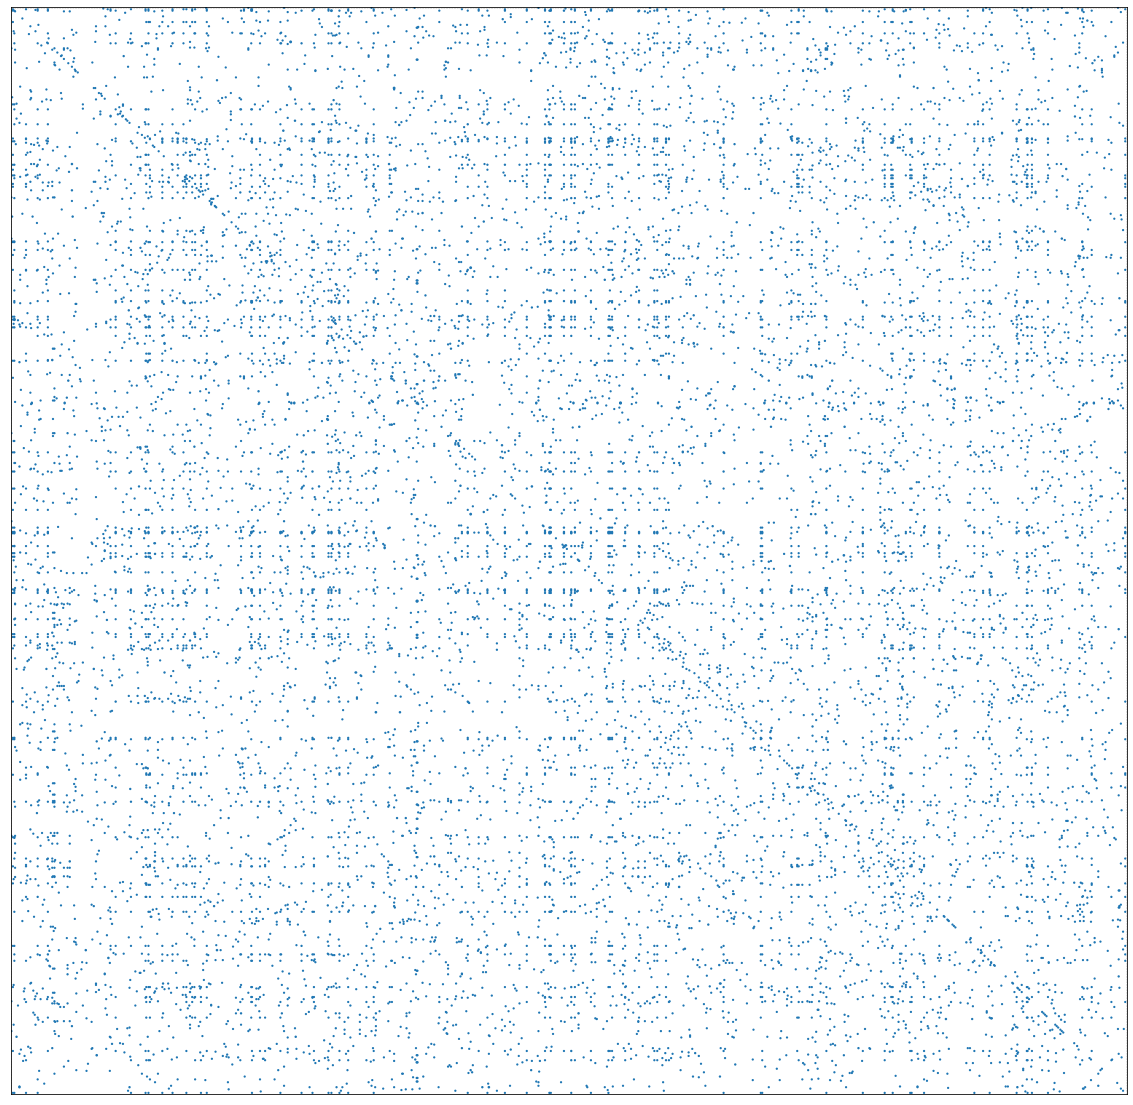

In [246]:
gridmap(cost_matrix)
#plt.savefig('cost_m')

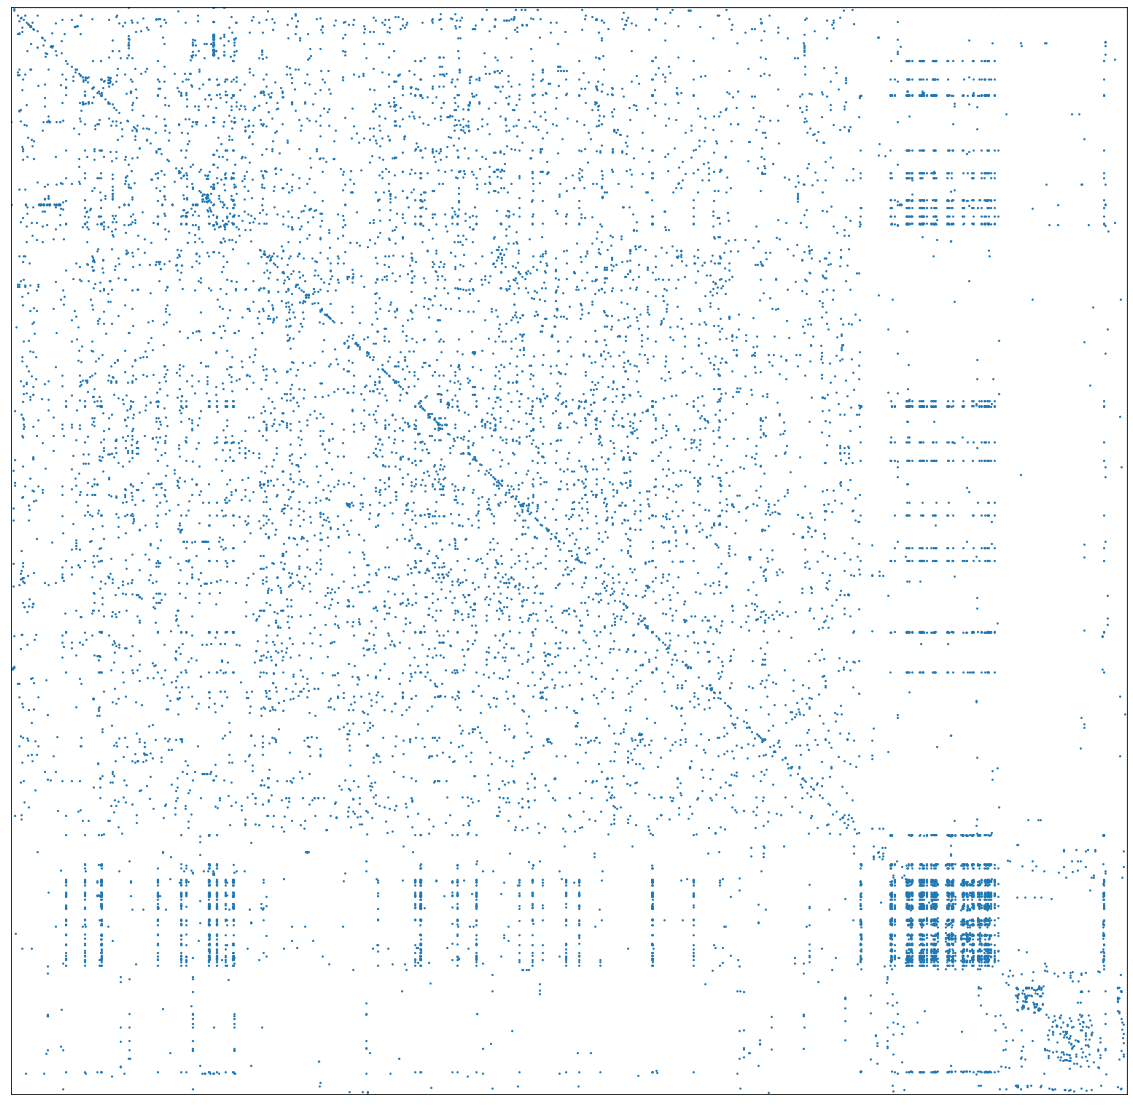

In [247]:
gridmap(dist_matrix)
#plt.savefig('dist_m')

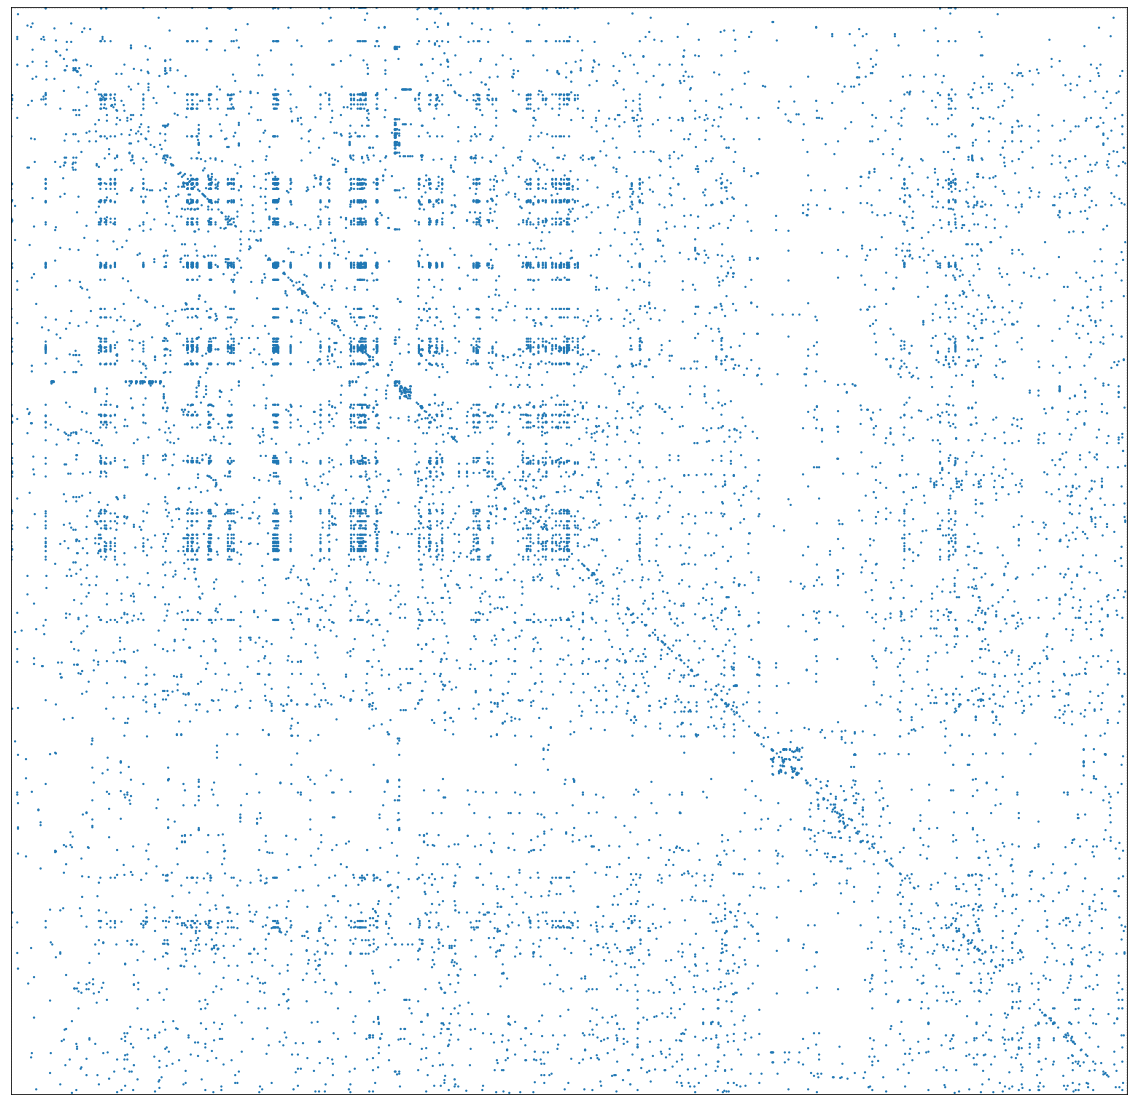

In [226]:
gridmap(A_right)